# Train HOTS model and run inference

In [17]:
from __future__ import print_function
import argparse
import os
import glob
from random import shuffle
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from event_Python import eventvision
from lib.noise_filter import remove_isolated_pixels
from lib.layer_operations import visualise_time_surface_for_event_stream, initialise_time_surface_prototypes, \
    generate_layer_outputs, train_layer, visualise_activations, generate_histogram
from lib.utils import euclidean_dist

##  Configure network parameters 

In [2]:
N_1 = 4
tau_1 = 20000.
r_1 = 2

K_N = 2
K_tau = 2
K_r = 2

N_2 = N_1 * K_N
tau_2 = tau_1 * K_tau
r_2 = r_1 * K_r

N_3 = N_2 * K_N
tau_3 = tau_2 * K_tau
r_3 = r_2 * K_r

## Read in event data files

In [3]:
input_folders_training = [
    'datasets/mnist/Train/0',
    'datasets/mnist/Train/1',
    'datasets/mnist/Train/2',
    'datasets/mnist/Train/3',
    'datasets/mnist/Train/4',
    'datasets/mnist/Train/5',
    'datasets/mnist/Train/6',
    'datasets/mnist/Train/7',
    'datasets/mnist/Train/8',
    'datasets/mnist/Train/9']

num_files_per_folder = 4

input_files_all = []

for folder in input_folders_training:
    input_files = glob.glob(os.path.join(folder, '*.bin'))[:num_files_per_folder]
    input_files_all.extend(input_files)
    print('Num files from {}: {}'.format(folder, len(input_files)))
    
# shuffle order of files to prevent reading same digit's files consecutively

shuffle(input_files_all)

ev = eventvision.read_dataset(input_files_all[0])

# filter out outliers

event_data = []
event_data_filt = []

for f in input_files_all:
    ev_data = eventvision.read_dataset(f).data
    ev_data_filt = remove_isolated_pixels(ev_data, eps=3, min_samples=20)[0]

    # ensure time stamps in event stream are monotonically increasing

    if len(event_data) > 0:
        ts_start_0 = event_data[-1].ts

        for i in range(len(ev_data)):
            ev_data[i].ts += ts_start_0

    if len(event_data_filt) > 0:
        ts_start_1 = event_data_filt[-1].ts

        for i in range(len(ev_data_filt)):
            ev_data_filt[i].ts += ts_start_1

    event_data.extend(ev_data)
    event_data_filt.extend(ev_data_filt)

    print('length event stream:', len(ev_data), len(ev_data_filt))

Num files from datasets/mnist/Train/0: 4
Num files from datasets/mnist/Train/1: 4
Num files from datasets/mnist/Train/2: 4
Num files from datasets/mnist/Train/3: 4
Num files from datasets/mnist/Train/4: 4
Num files from datasets/mnist/Train/5: 4
Num files from datasets/mnist/Train/6: 4
Num files from datasets/mnist/Train/7: 4
Num files from datasets/mnist/Train/8: 4
Num files from datasets/mnist/Train/9: 4
length event stream: 4355 4127
length event stream: 4096 3889
length event stream: 2092 1817
length event stream: 5545 5342
length event stream: 5908 5700
length event stream: 3853 3631
length event stream: 4542 4322
length event stream: 2883 2669
length event stream: 2484 2228
length event stream: 3999 3817
length event stream: 3010 2813
length event stream: 4989 4787
length event stream: 2096 1896
length event stream: 2220 1985
length event stream: 5028 4802
length event stream: 4994 4796
length event stream: 2742 2539
length event stream: 2693 2473
length event stream: 3993 3767
l

## Train time surface prototypes for layer 1

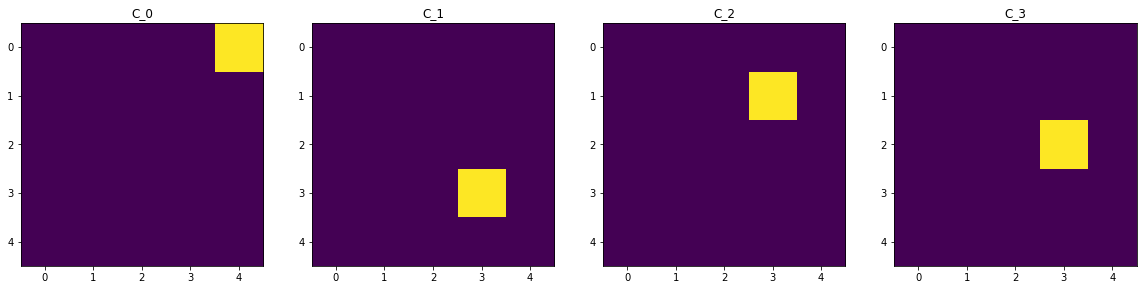

In [4]:
C_1 = initialise_time_surface_prototypes(N_1, tau_1, r_1, ev.width, ev.height, event_data_filt, plot=True)

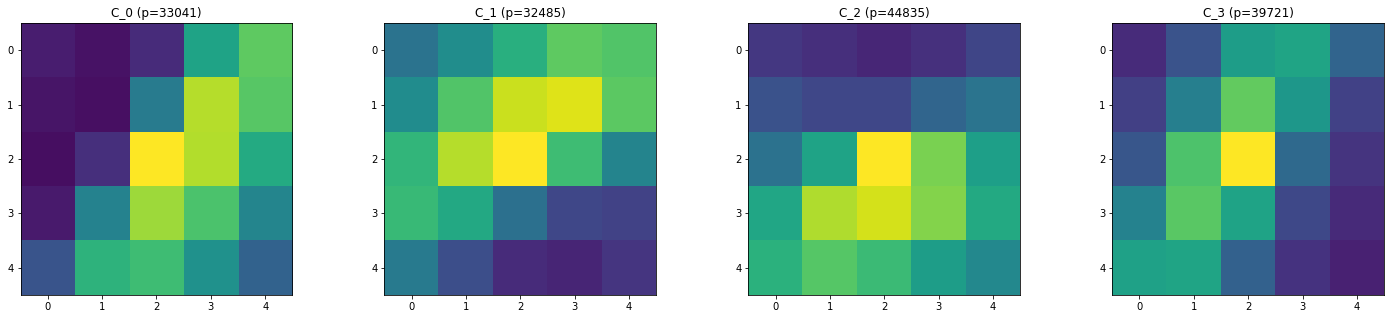

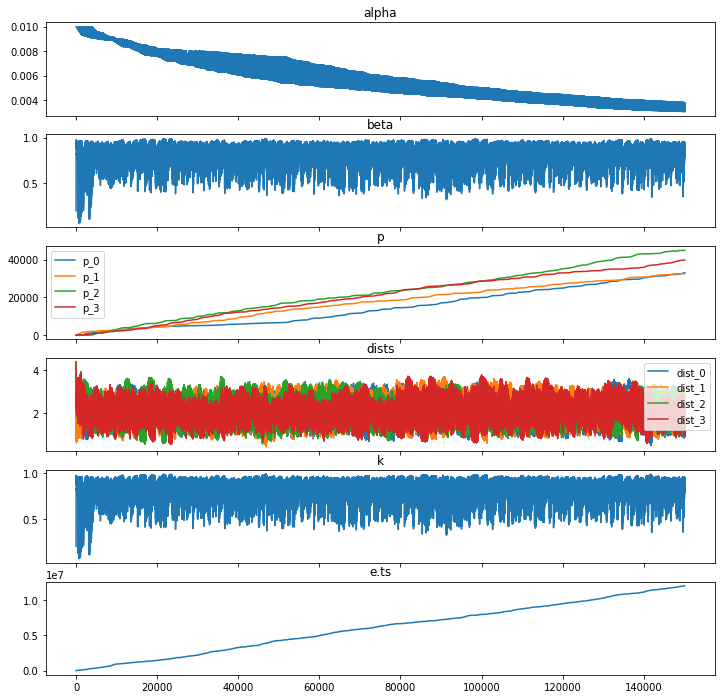

In [5]:
train_layer(C_1, N_1, tau_1, r_1, ev.width, ev.height, event_data_filt, num_polarities=2, layer_number=1, plot=True)

## Train time surface prototypes for layer 2

In [6]:
# generate event data at output of layer 1 (using the trained features)

event_data_2 = generate_layer_outputs(num_polarities=2, features=C_1, tau=tau_1, r=r_1, width=ev.width,
                                      height=ev.height, events=event_data_filt)

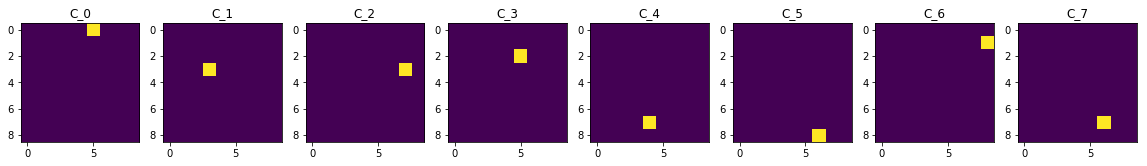

In [7]:
C_2 = initialise_time_surface_prototypes(N_2, tau_2, r_2, ev.width, ev.height, event_data_2, plot=True)

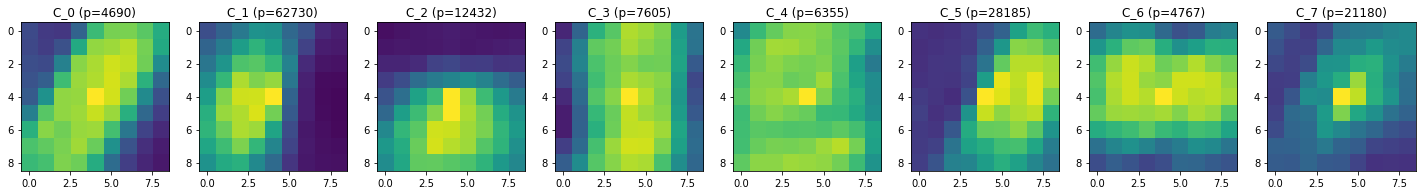

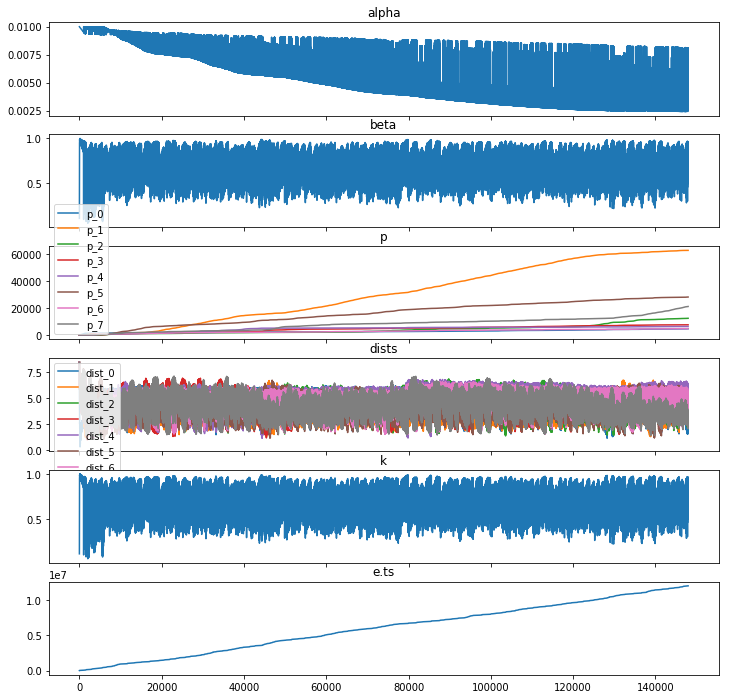

In [8]:
train_layer(C_2, N_2, tau_2, r_2, ev.width, ev.height, event_data_2, num_polarities=N_1, layer_number=2, plot=True)

## Train time surface prototypes for layer 3

In [9]:
# generate event data at output of layer 1 (using the trained features)

event_data_3 = generate_layer_outputs(num_polarities=N_1, features=C_2, tau=tau_2, r=r_2, width=ev.width,
                                      height=ev.height, events=event_data_2)

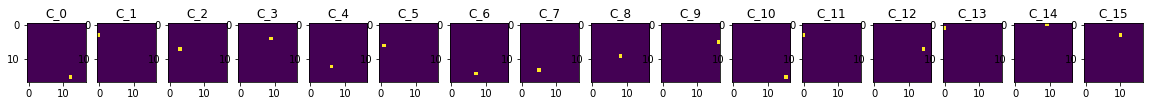

In [10]:
C_3 = initialise_time_surface_prototypes(N_3, tau_3, r_3, ev.width, ev.height, event_data_3, plot=True)

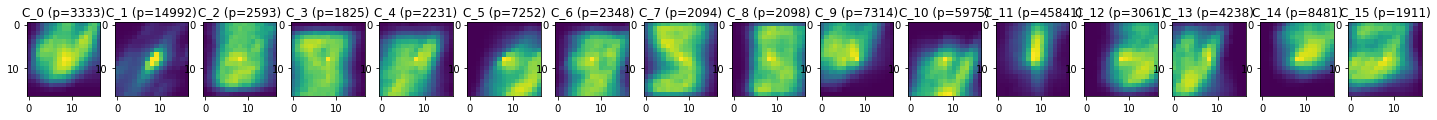

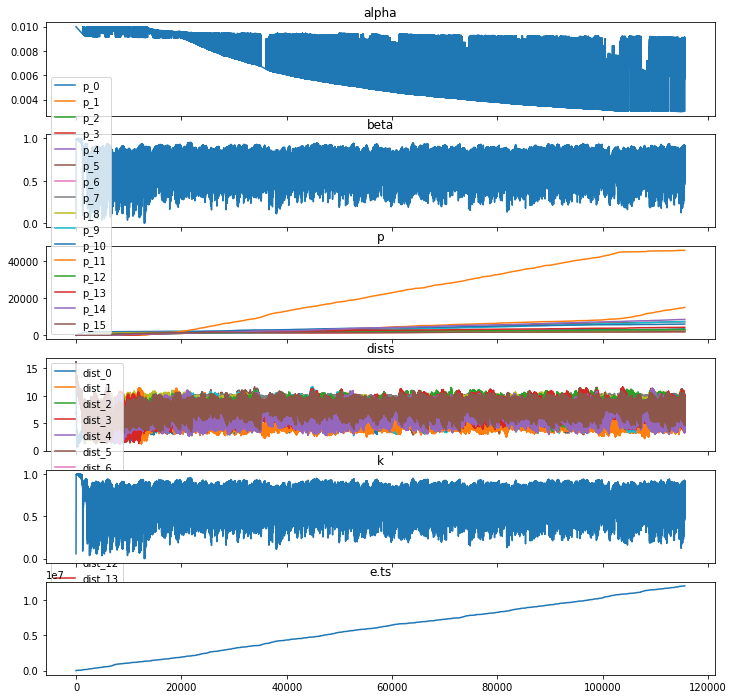

In [11]:
train_layer(C_3, N_3, tau_3, r_3, ev.width, ev.height, event_data_3, num_polarities=N_2, layer_number=3, plot=True)

## Plot activations of layer 1

In [12]:
ev = eventvision.read_dataset(input_files_all[0])
ev_data = ev.data
ev_data = ev_data[:len(ev_data) / 3]
ev_data_filt = remove_isolated_pixels(ev.data, eps=3, min_samples=20)[0]
events_single_digit_2 = generate_layer_outputs(num_polarities=2, features=C_1, tau=tau_1, r=r_1, width=ev.width, height=ev.height, events=ev_data)

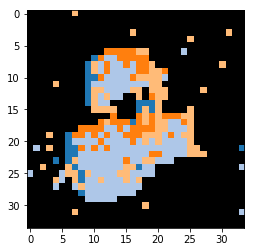

In [13]:
visualise_activations(4, ev.width, ev.height, events_single_digit_2[:3500])

## Generate histograms from output of last layer

* Generate a histogram from a single sample from each digit class (from the training event data).
* These histograms will be compared to when doing inference on test data to determine which digit the event stream corresponds to.

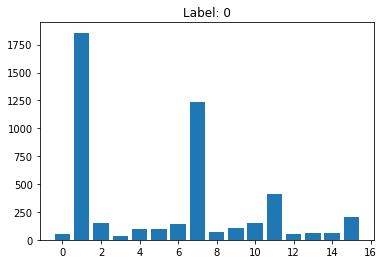

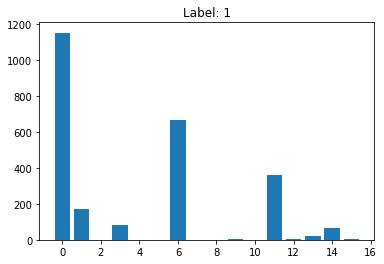

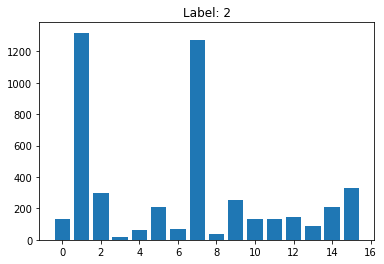

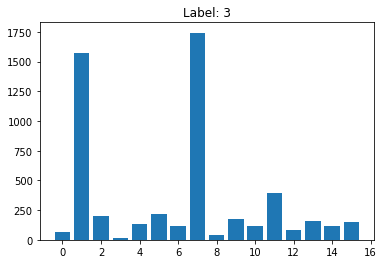

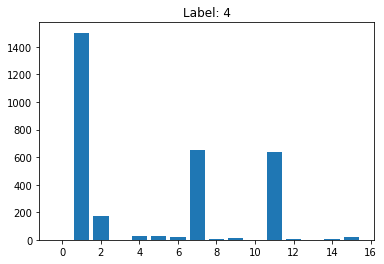

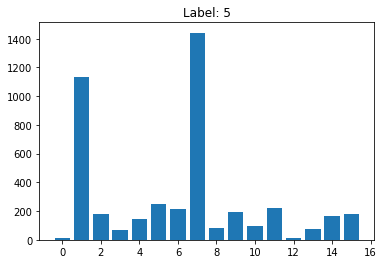

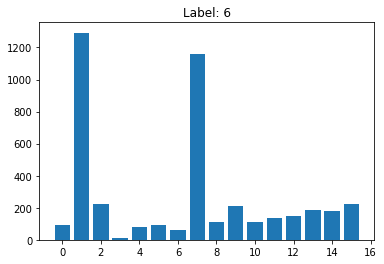

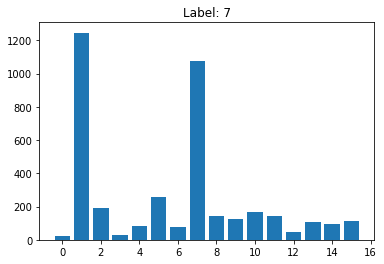

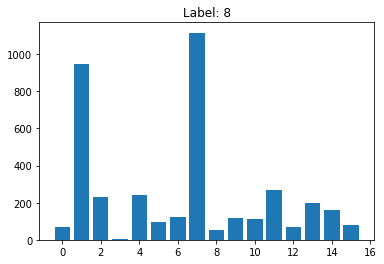

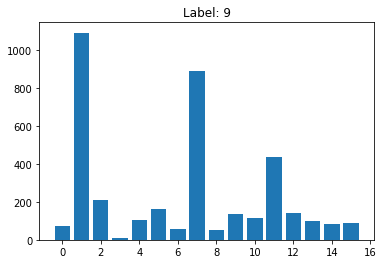

In [15]:
input_folders_training_hist = [
    'datasets/mnist/Train/0',
    'datasets/mnist/Train/1',
    'datasets/mnist/Train/2',
    'datasets/mnist/Train/3',
    'datasets/mnist/Train/4',
    'datasets/mnist/Train/5',
    'datasets/mnist/Train/6',
    'datasets/mnist/Train/7',
    'datasets/mnist/Train/8',
    'datasets/mnist/Train/9']

hist_training_data = []

for folder in input_folders_training_hist:
    input_file = sorted(glob.glob(os.path.join(folder, '*.bin')))[0]
    
    hist_data = generate_histogram(input_file, C_1, C_2, C_3, N_1, N_2, N_3, r_1, r_2, r_3, tau_1, tau_2, tau_3, True)
    
    plt.subplots()
    plt.bar(range(N_3), hist_data['histogram'])
    plt.title('Label: {}'.format(hist_data['label']))
    
    hist_training_data.append(hist_data)
    
plt.show()

### Compare histograms from same class

* Generate a set of histograms for several samples from each digit class in the test dataset.
* These will be compared to the histograms on the training data to decide which class they belong to.

In [16]:
root_test_folder = 'datasets/mnist/Test/'

test_histograms = []

for digit in range(10):
    # for each digit, feed the events through each layer of the network and calculate a histogram from the output of the last layer
    
    print('Generating histograms for digit', digit)
    
    folder = os.path.join(root_test_folder, str(digit))
    input_files = sorted(glob.glob(os.path.join(folder, '*.bin')))[:10]
    
    hist_data_digit = []

    for input_file in input_files:
        hist_data = generate_histogram(input_file, C_1, C_2, C_3, N_1, N_2, N_3, r_1, r_2, r_3, tau_1, tau_2, tau_3, True)
        hist_data_digit.append(hist_data)
        
    test_histograms.append(hist_data_digit)

Generating histograms for digit 0
Generating histograms for digit 1
Generating histograms for digit 2
Generating histograms for digit 3
Generating histograms for digit 4
Generating histograms for digit 5
Generating histograms for digit 6
Generating histograms for digit 7
Generating histograms for digit 8
Generating histograms for digit 9


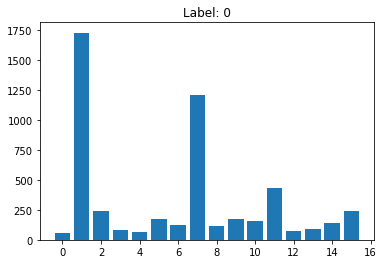

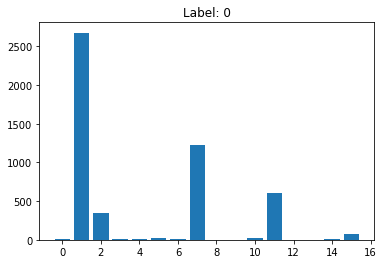

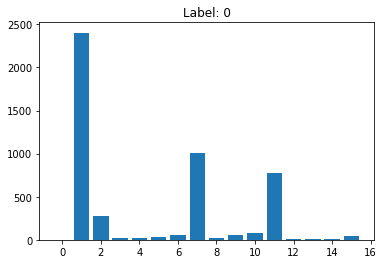

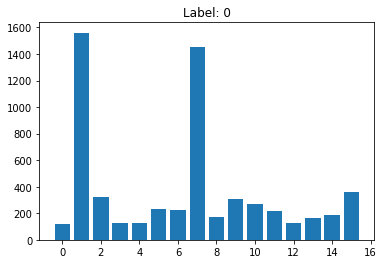

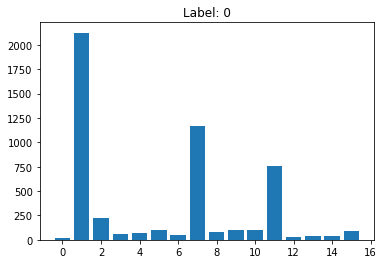

In [18]:
# plot a few of the histograms from a class

digit_to_plot = 0

for hist_data in test_histograms[digit_to_plot][:5]:
    plt.figure()
    plt.bar(range(N_3), hist_data['histogram'])
    plt.title('Label: {}'.format(hist_data['label']))

    plt.show()

### Plot confusion matrix

In [46]:
# calculate which training histogram is closest to each test digit's histogram

y_true = []
y_pred = []
    
for test_digit in range(10):
    print('Digit', test_digit)
    for hist_data in test_histograms[test_digit]:
        dists = []

        for training_digit in range(10):
            dist = euclidean_dist(hist_data['histogram'], hist_training_data[training_digit]['histogram'])
            dists.append(dist)

        nearest_label = np.argmin(dists)
        y_true.append(test_digit)
        y_pred.append(nearest_label)

        print('actual label: {}, predicted label: {}'.format(test_digit, nearest_label))
        

Digit 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 2
actual label: 0, predicted label: 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 0
actual label: 0, predicted label: 1
Digit 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
actual label: 1, predicted label: 1
Digit 2
actual label: 2, predicted label: 1
actual label: 2, predicted label: 0
actual label: 2, predicted label: 7
actual label: 2, predicted label: 9
actual label: 2, predicted label: 9
actual label: 2, predicted label: 0
actual label: 2, predicted label: 7
actu

In [47]:
cnf_matrix = confusion_matrix(y_true, y_pred)

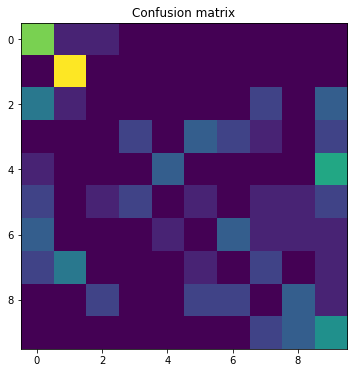

array([[ 8,  1,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  1,  0,  0,  0,  0,  0,  2,  0,  3],
       [ 0,  0,  0,  2,  0,  3,  2,  1,  0,  2],
       [ 1,  0,  0,  0,  3,  0,  0,  0,  0,  6],
       [ 2,  0,  1,  2,  0,  1,  0,  1,  1,  2],
       [ 3,  0,  0,  0,  1,  0,  3,  1,  1,  1],
       [ 2,  4,  0,  0,  0,  1,  0,  2,  0,  1],
       [ 0,  0,  2,  0,  0,  2,  2,  0,  3,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  3,  5]], dtype=int64)

In [55]:
plt.figure(figsize=(6, 6))
plt.imshow(cnf_matrix)
plt.title('Confusion matrix')
plt.show()

cnf_matrix